# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [77]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg


# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 7))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [78]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = False 
is_display = True
is_optimization = True 
is_optimization_psf = True
is_flip = False
is_measurement = True

# data files for parameters and measuremets 
if is_measurement:
    if(False):
        matlab_val_file = './Data/DROPLETS/allAmp_red.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
        matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   
        matlab_val_name = 'allAmp_red'
        matlab_par_name = 'myParameterNew'  
    if(True):
        matlab_val_file = './Data/DROPLETS/S19_multiple/S19_subroi1.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
        matlab_par_file = './Data/DROPLETS/S19_multiple/Parameter.mat'   
        matlab_val_name = 'allAmp_red'
        matlab_par_name = 'myParameter' 
        
else:
    matlab_val_file = './Data/DROPLETS/RESULTS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat' 
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,0.,-0.,0)) # representing the 9 first zernike coefficients in noll-writings 
dn = .5 # refractive index of the object (difference)
NAc = .52
shiftIcY = -1
shiftIcX = -1

'''Define Optimization Parameters'''
my_learningrate = 1e-3  # learning rate
lambda_tv =  10e-0 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 0
lambda_neg = 10

Niter = 10000
Ndisplay = 15


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

# Generate Test-Object

In [79]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname=matlab_par_name)

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname=matlab_val_name, is_complex=True)

if(is_flip):
    np_meas_raw = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas_raw = matlab_val
    print('do we need to flip the data?! -> Observe FFT!!')



''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=shiftIcY
muscat.shiftIcX=shiftIcX
muscat.dn = dn
muscat.NAc = NAc
#muscat.lambdaM = .7
#muscat.dz = muscat.lambdaM/4
#print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=(muscat.dz,muscat.dx,muscat.dy), obj_type ='sphere', diameter = 1, dn = muscat.dn)

# introduce zernike factors here
muscat.zernikefactors = zernikefactors


do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [80]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True, is_padding=is_padding, dropout_prob=1)
print(muscat.Ic.shape)

----------> Be aware: We are taking aberrations into account!
We are weighing the Intensity int the illu-pupil!
Shifting the illumination in X by: -1 Pixel
Shifting the illumination in Y by: -1 Pixel
Number of Illumination Angles / Plane waves: 49
(32, 32)


# Generate Computational Graph (fwd model)

Buildup Q-PHASE Model 


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


----------> Bringing field back to focus


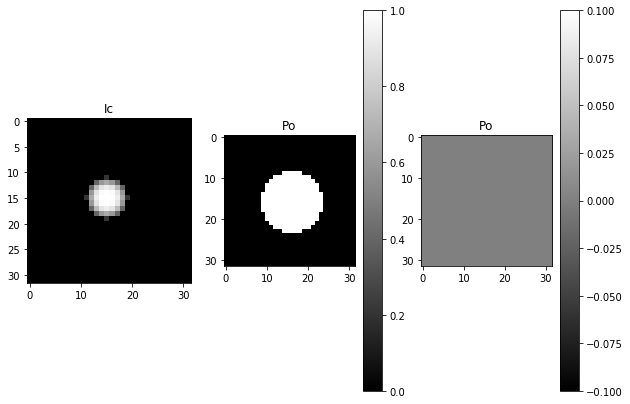

In [81]:
tf_fwd = muscat.computemodel()

if(is_display): 
    plt.subplot(131), plt.title('Ic'), plt.imshow(muscat.Ic)
    plt.subplot(132), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()
    plt.subplot(133), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.myaberration))), plt.colorbar(), plt.show()

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

Evtl unwrap it!


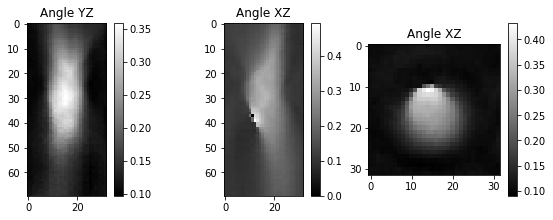

In [82]:
print('Evtl unwrap it!')

# this is the initial guess of the reconstruction
np_meas=np_meas_raw#*np.exp(1j*np.pi)

if(True): # good for the experiment
    init_guess = np.angle(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**2
    init_guess = init_guess/np.max(init_guess)*muscat.dn
elif(False): # good for the simulation
    init_guess = -np.abs(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**2
    init_guess = init_guess/np.max(init_guess)*muscat.dn
    init_guess = np.flip(init_guess,0)
elif(False):
    init_guess = np.ones(np_meas.shape)*muscat.dn
elif(True):
    init_guess = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 7, dn = muscat.dn)
else:
    init_guess = np.random.randn(np_meas.shape[0],init_guess.shape[1],init_guess.shape[2])*muscat.dn

        

if(is_display): plt.subplot(231), plt.title('Angle YZ'),plt.imshow(init_guess[:,init_guess.shape[1]//2,:]), plt.colorbar()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(init_guess[:,:,init_guess.shape[1]//2]), plt.colorbar()
if(is_display): plt.subplot(233), plt.title('Angle XZ'),plt.imshow(init_guess[init_guess.shape[0]//2,:,:]), plt.colorbar(),plt.show()


#### Optimize

# Estimate the Phase difference between Measurement and Simulation

In [83]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=init_guess.shape)
             
'''Define Cost-function'''
tf_lambda_tv = tf.placeholder(tf.float32, [])
#tf_tvloss = tf_lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj_phase, BetaVals = [muscat.dx,muscat.dy,muscat.dz], epsR=.001)  #Alernatively tf_total_variation_regularization # total_variation
tf_tvloss = tf_lambda_tv*reg.total_variation_iso_conv(muscat.TF_obj_phase,  eps=.1, step_sizes = [muscat.dx,muscat.dy,muscat.dz])  #Alernatively tf_total_variation_regularization # total_variation
#tf_tvloss = tf_lambda_tv*10*reg.l1_reg(muscat.TF_obj_phase)
#tf_tvloss = tf_lambda_tv*reg.l2_reg(muscat.TF_obj_phase)

#tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj_phase, minval=0)
#tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj_phase, maxval=.2) 
tf_negsqrloss = lambda_neg*reg.RegularizeNegSqr(muscat.TF_obj_phase)
tf_globalphase = tf.Variable(0., tf.float32, name='var_phase')
tf_globalabs = tf.Variable(2., tf.float32, name='var_abs')# 
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_fwd  - (tf_meas/tf.cast(tf.abs(tf_globalabs), tf.complex64)*tf.exp(1j*tf.cast(tf_globalphase, tf.complex64))))) # allow a global phase parameter to avoid unwrapping effects
tf_loss = tf_fidelity +  tf_negsqrloss + tf_tvloss #tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
'''Define Optimizer'''
tf_learningrate = tf.placeholder(tf.float32, []) 
tf_optimizer = tf.train.AdamOptimizer(tf_learningrate)
tf_grads = tf.gradients(tf_loss, [muscat.TF_obj_phase])[0]
#tf_optimizer = tf.train.MomentumOptimizer(tf_learningrate, momentum = .9, use_nesterov=True)

#tf_optimizer = tf.train.ProximalGradientDescentOptimizer(tf_learningrate)
tf_lossop = tf_optimizer.minimize(tf_loss)

    
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if is_optimization:
    if is_padding:
        # Pad object with zeros along X/Y
        init_guess_tmp= np.zeros(muscat.mysize)# + 1j*np.zeros(muscat.mysize)
        init_guess_tmp[:,muscat.Nx//2-muscat.Nx//4:muscat.Nx//2+muscat.Nx//4, muscat.Ny//2-muscat.Ny//4:muscat.Ny//2+muscat.Ny//4] =init_guess
        init_guess = init_guess_tmp

    sess.run(tf.assign(muscat.TF_obj_phase, init_guess)); # assign abs of measurement as initial guess of 

my_fwd = sess.run(tf_fwd)#, feed_dict={muscat.TF_obj:obj})
mysize = my_fwd.shape



My Init Phase is :0.9743488422955845


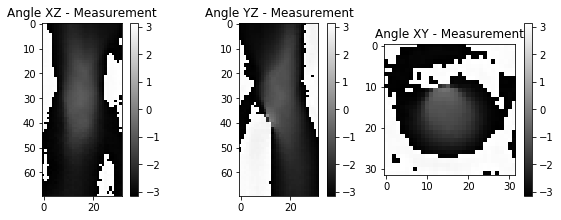

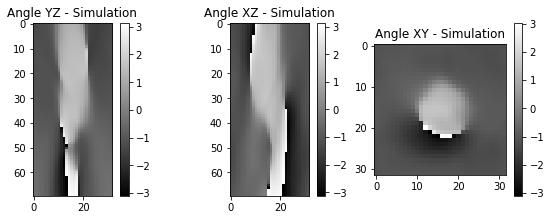

In [84]:
# We assume, that there is a global phase mismatch between measurment and first estimate of the fwd model, this can be estimated by the difference of mean phase of the two
# subtracting the mean phase from either measurement or the fwd model could help to speed up the optimization
# this is the initial guess of the reconstruction
np_meas = matlab_val
myinitphase = np.mean(np.angle(np_meas))-np.mean(np.angle(my_fwd))
print('My Init Phase is :'+str(myinitphase))
np_meas=np_meas*np.exp(-1j*(myinitphase+2)) # subtract globaphase - anyway we want to optimize for that, but now the global phase can be assumed to be 0 initally
if(is_display): plt.subplot(231), plt.title('Angle XZ - Measurement'),plt.imshow(np.angle(np_meas)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Angle YZ - Measurement'),plt.imshow(np.angle(np_meas)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Angle XY - Measurement'),plt.imshow(np.angle(np_meas)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.subplot(234), plt.title('Angle YZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY - Simulation'),plt.imshow(np.angle(my_fwd)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

# assert some memory 
iter_last = 0
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
result_phaselist = []
result_reallist = []
globalphaselist = []
globalabslist = []

In [85]:
#%%
''' Optimize the model '''
print('Start optimizing')
np_meas = matlab_val # use the previously simulated data
for iterx in range(iter_last,Niter):
    if iterx == 1000:
        my_learningrate = my_learningrate*.1
    # try to optimize
    
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_res_phase, my_loss, my_fidelity, my_negloss, my_tvloss, myglobalphase, myglobalabs, myfwd =  \
            sess.run([muscat.TF_obj_phase, tf_loss, tf_fidelity, tf_negsqrloss, tf_tvloss, tf_globalphase, tf_globalabs, tf_fwd], \
                     feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:lambda_tv/((iterx+1)/100)})

        print('Loss@'+str(iterx)+': ' + str(my_loss) + ' - Fid: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', TV: '+str(my_tvloss)+' G-Phase:'+str(myglobalphase)+' G-ABS: '+str(myglobalabs))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myneglosslist.append(my_negloss)
        mytvlosslist.append(my_tvloss)
        result_phaselist.append(my_res_phase)
        globalphaselist.append(myglobalphase)
        globalabslist.append(myglobalabs)  
        if(False):
            if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

    else:
        _, mygrads = sess.run([tf_lossop,tf_grads], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:lambda_tv/((iterx+1)/100)})
        #plt.imshow(np.abs(my_res[:,50,:]))
        #print(mygrads)
        #print(mygrads.shape)
        if(False):
            if(is_display): plt.subplot(231), plt.title('Grad XZ'),plt.imshow(np.angle(myfwd)[:,mygrads.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(232), plt.title('Grad XZ'),plt.imshow(np.angle(myfwd)[:,:,mygrads.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(233), plt.title('Grad XY'),plt.imshow(np.angle(myfwd)[mygrads.shape[0]//2,:,:]), plt.colorbar(), plt.show()

            if(is_display): plt.subplot(234), plt.title('Grad XZ'),plt.imshow(np.abs(myfwd)[:,mygrads.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Grad XZ'),plt.imshow(np.abs(myfwd)[:,:,mygrads.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Grad XY'),plt.imshow(np.abs(myfwd)[mygrads.shape[0]//2,:,:]), plt.colorbar(), plt.show()

        

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

Start optimizing
Loss@0: 7491112.5 - Fid: 20369.363, Neg: 0.0, TV: 7470743.0 G-Phase:0.0 G-ABS: 2.0
Loss@15: 459423.16 - Fid: 8502.568, Neg: 0.0, TV: 450920.6 G-Phase:-0.01296331 G-ABS: 2.013525
Loss@30: 236778.83 - Fid: 7397.1055, Neg: 0.0, TV: 229381.72 G-Phase:-0.020751065 G-ABS: 2.0262136
Loss@45: 159879.4 - Fid: 6574.0503, Neg: 0.0, TV: 153305.36 G-Phase:-0.024452282 G-ABS: 2.0383902
Loss@60: 121035.47 - Fid: 5975.6934, Neg: 0.0, TV: 115059.77 G-Phase:-0.024509918 G-ABS: 2.0501049
Loss@75: 97768.25 - Fid: 5588.712, Neg: 0.0, TV: 92179.54 G-Phase:-0.023565032 G-ABS: 2.0614333
Loss@90: 81996.98 - Fid: 5143.2554, Neg: 0.0, TV: 76853.72 G-Phase:-0.024527658 G-ABS: 2.0723991
Loss@105: 70646.055 - Fid: 4779.674, Neg: 0.0, TV: 65866.38 G-Phase:-0.023330502 G-ABS: 2.0828862
Loss@120: 62184.137 - Fid: 4534.3877, Neg: 0.0, TV: 57649.75 G-Phase:-0.021799918 G-ABS: 2.0929244
Loss@135: 55514.785 - Fid: 4292.538, Neg: 0.0007497105, TV: 51222.246 G-Phase:-0.019948771 G-ABS: 2.1025386
Loss@150: 5

# Display result - FFT

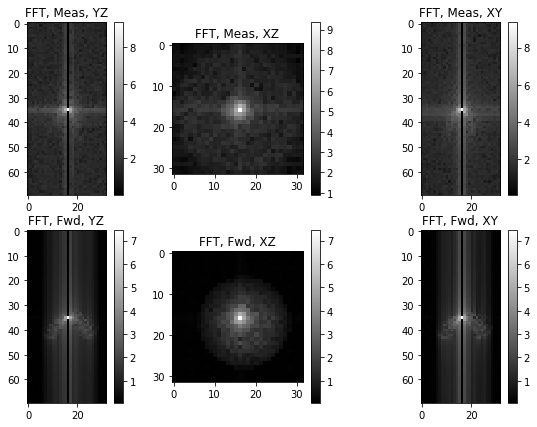

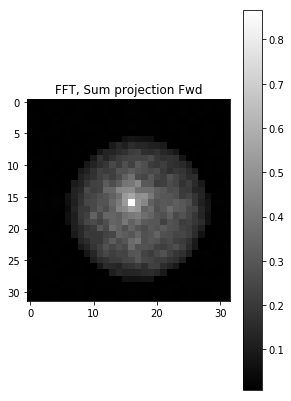

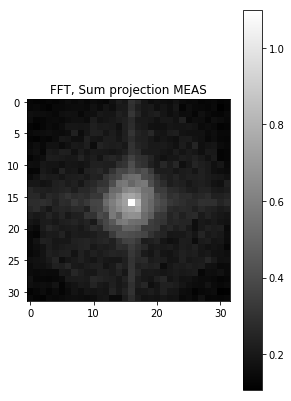

In [86]:
iter_last = iterx
#%% Display the results
is_display=True
myfwd, mymeas, my_res_phase = sess.run([tf_fwd, tf_meas, muscat.TF_obj_phase], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(np_meas))**.2)[:,mymeas.shape[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[mymeas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,mymeas.shape[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Fwd, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Fwd, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Fwd, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,myfwd.shape[2]//2]), plt.colorbar(), plt.show()    

    
if(is_display): plt.subplot(121), plt.title('FFT, Sum projection Fwd'), plt.imshow(np.std(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2),0)), plt.colorbar(), plt.show()    
if(is_display): plt.subplot(121), plt.title('FFT, Sum projection MEAS'), plt.imshow(np.std(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2),0)), plt.colorbar(), plt.show()    


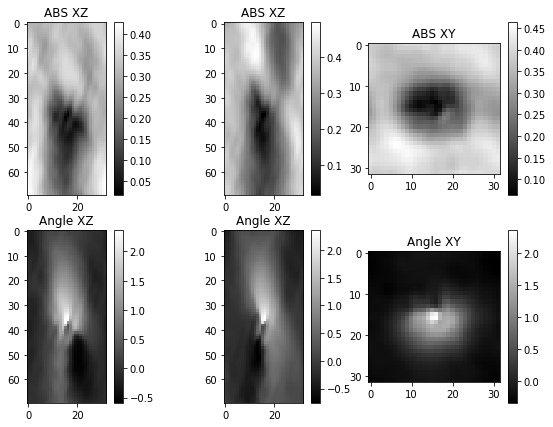

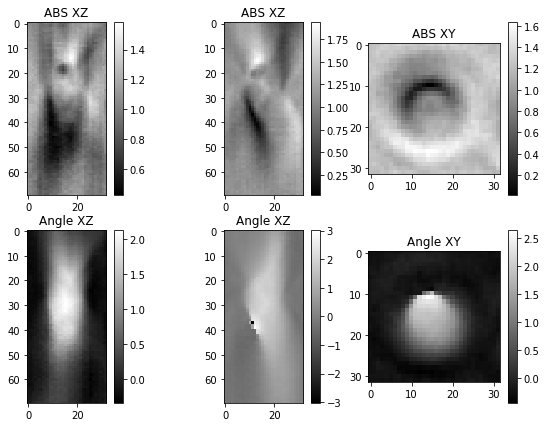

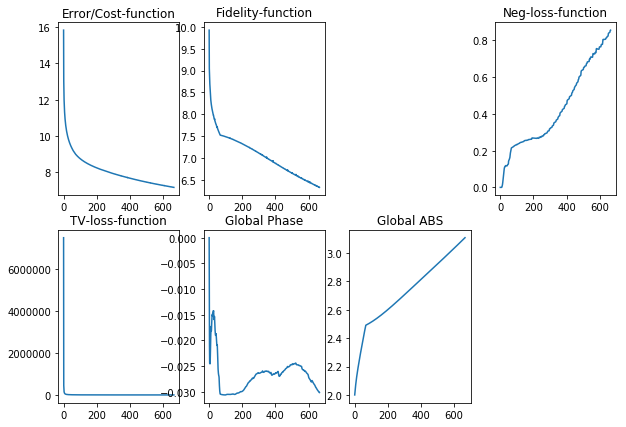

(<matplotlib.axes._subplots.AxesSubplot at 0x27d50cef160>,
 Text(0.5,1,'Global ABS'),
 None)

In [87]:
# This is the reconstruction
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

# This is the measurment
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar(), plt.show()

# diplay the error over time
plt.subplot(241), plt.title('Error/Cost-function'), plt.plot(np.log(np.array(mylosslist)))#, plt.show()
plt.subplot(242), plt.title('Fidelity-function'), plt.plot(np.log(np.array(myfidelitylist)))#, plt.show()
#plt.subplot(243), plt.title('Pos-loss-function'), plt.plot(np.array(myposlosslist))#, plt.show()
plt.subplot(244), plt.title('Neg-loss-function'), plt.plot(np.array(myneglosslist))#, plt.show()
plt.subplot(245), plt.title('TV-loss-function'), plt.plot(np.array(mytvlosslist))#, plt.show()
plt.subplot(246), plt.title('Global Phase'), plt.plot(np.array(globalphaselist))#, plt.show()
plt.subplot(247), plt.title('Global ABS'), plt.plot(np.array(globalabslist)), plt.show()



# Display Result Refractive index

# Display results ABS/Angle - FWD model

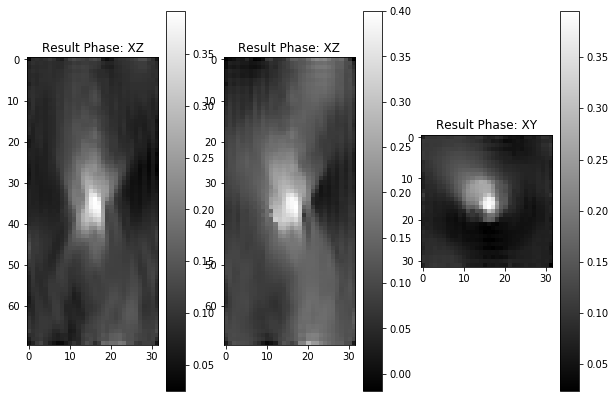

In [88]:
if(is_display): plt.subplot(131), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,my_res_phase.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(132), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,:,my_res_phase.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(133), plt.title('Result Phase: XY'),plt.imshow(my_res_phase[my_res_phase.shape[0]//2,:,:]), plt.colorbar(), plt.show()


[ 0.03018089 -0.07611675 -0.2651907  -0.01786709 -0.40387747  0.10914756
  0.08888706  0.00957858  0.13799262]


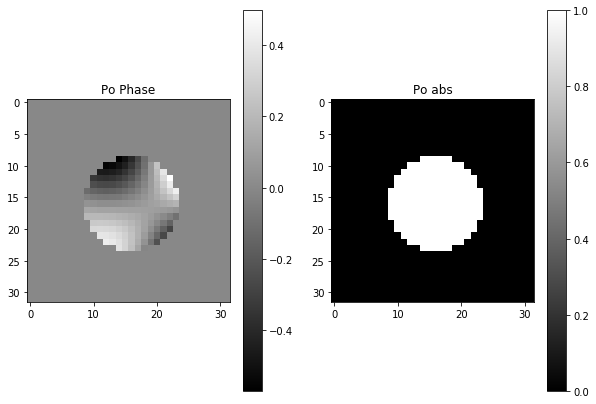

Assuming first axis is time


In [89]:
#plt.subplot(121), plt.imshow(np.angle(sess.run(muscat.TF_Po.eval)))
print(np.real(sess.run(muscat.TF_zernikefactors)))
plt.subplot(121), plt.title('Po Phase'), plt.imshow(np.fft.fftshift(np.angle(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
plt.subplot(122), plt.title('Po abs'), plt.imshow(np.fft.fftshift(np.abs(sess.run(muscat.TF_Po_aberr)))), plt.colorbar(), plt.show()

#np.save(savepath+'/myrefractiveindex.npy',np.array(resultlist))
data.export_realdatastack_h5(savepath+'/myrefractiveindex.h5', 'temp', np.array(result_phaselist))

# Display recovered pupil

# Save results

# %% save the results
np.save(savepath+'/rec.npy', my_res)
data.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
data.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
data.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')